In [2]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [12]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls) 

def draw_home_plate(catcher_perspective=True, ls='k-'):
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else: 
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

def draw_attack_zones():
  # outer heart / inner shadow
  plt.plot([-0.558, 0.558], [1.833,1.833], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, -0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([0.558, 0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, 0.558], [3.166,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3) 

  # outer shadow /  inner chase 
  plt.plot([-1.108, 1.108], [1.166,1.166], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, -1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([1.108, 1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, 1.108], [3.833,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3) 

  # outer chase 
  plt.plot([-1.666, 1.666], [0.5,0.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, -1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([1.666, 1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, 1.666], [4.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3) 

In [3]:
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [45]:
fastballs = all_pitches[all_pitches['TaggedPitchType'].isin(['Fastball','Cutter','Sinker','FourSeamFastBall','TwoSeamFastBall','OneSeamFastBall'])]
fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)

off_speed = all_pitches[all_pitches['TaggedPitchType'].isin(['ChangeUp','Splitter'])]
off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)

breaking_balls = all_pitches[all_pitches['TaggedPitchType'].isin(['Slider','Curveball','Knuckleball'])]
breaking_balls['whiff'] = np.where(breaking_balls['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_6576\2791632613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_6576\2791632613.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_6576\2791632613.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [60]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

os_preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','PlateLocHeight','PlateLocSide','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

bb_preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [61]:
fastballs_X = fastballs[preds]
fastballs_y = fastballs['whiff']

off_speed_X = off_speed[os_preds]
off_speed_y = off_speed['whiff']

breaking_balls_X = breaking_balls[bb_preds]
breaking_balls_y = breaking_balls['whiff']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(fastballs_X, fastballs_y, test_size=.33)

model_fastballs = XGBClassifier()
model_fastballs.fit(X_train, y_train)

y_pred = model_fastballs.predict(X_test)
predictions_fbs = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions_fbs)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.90%


In [68]:
X_train, X_test, y_train, y_test = train_test_split(off_speed_X, off_speed_y, test_size=.33)

model_os = XGBClassifier()
model_os.fit(X_train, y_train)

y_pred = model_os.predict(X_test)
predictions_os = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions_os)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.33%


In [75]:
X_train, X_test, y_train, y_test = train_test_split(breaking_balls_X, breaking_balls_y, test_size=.33)

model_bb = XGBClassifier()
model_bb.fit(X_train, y_train)

y_pred = model_bb.predict(X_test)
predictions_bb = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions_bb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.38%


In [63]:
# Get unique values
unique_values = fastballs['Pitcher'].unique()

# Create a dictionary to store subsets
subsets = {value: fastballs[fastballs['Pitcher'] == value] for value in unique_values}

In [64]:
fb_preds = model_fastballs.predict_proba(fastballs_X)[:,1]
mean_pred = np.mean(fb_preds)

skenes = subsets['Skenes, Paul']
skenes_X = skenes[preds]

whiff_preds = model_fastballs.predict_proba(skenes_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Paul Skenes fastball stuff+:{np.mean(stuff*100)}")

Paul Skenes fastball stuff+:170.300048828125


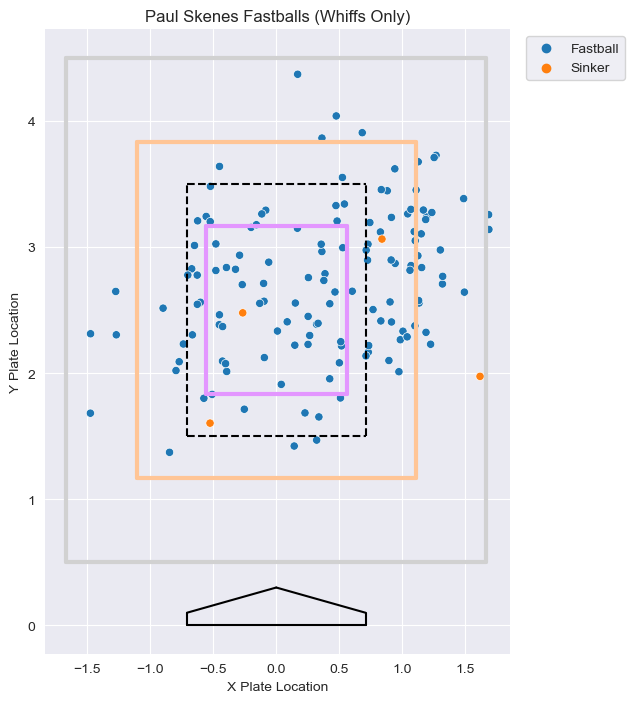

In [65]:
fig = plt.figure(figsize=(6,9))
fig = sns.scatterplot(data=skenes[skenes['PitchCall'] == 'StrikeSwinging'], x='PlateLocSide', y='PlateLocHeight',
                      hue='TaggedPitchType')

draw_sz(ls='k--')
draw_home_plate(False)
draw_attack_zones()
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine(left=True, bottom=True)
plt.title('Paul Skenes Fastballs (Whiffs Only)')
plt.xlabel('X Plate Location')
plt.ylabel('Y Plate Location')
plt.show()

In [66]:
# Get unique values
unique_values = off_speed['Pitcher'].unique()

# Create a dictionary to store subsets
subsets = {value: off_speed[off_speed['Pitcher'] == value] for value in unique_values}

In [69]:
preds = model_os.predict_proba(off_speed_X)[:,1]
mean_pred = np.mean(preds)

skenes_os = subsets['Skenes, Paul']
skenes_os_X = skenes[os_preds]

whiff_preds = model_os.predict_proba(skenes_os_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Paul Skenes Off Speed stuff+:{np.mean(stuff*100)}")

Paul Skenes Off Speed stuff+:65.11180114746094


In [70]:
skenes_pitches = skenes_os['TaggedPitchType'].unique()
print(skenes_pitches)

['ChangeUp']


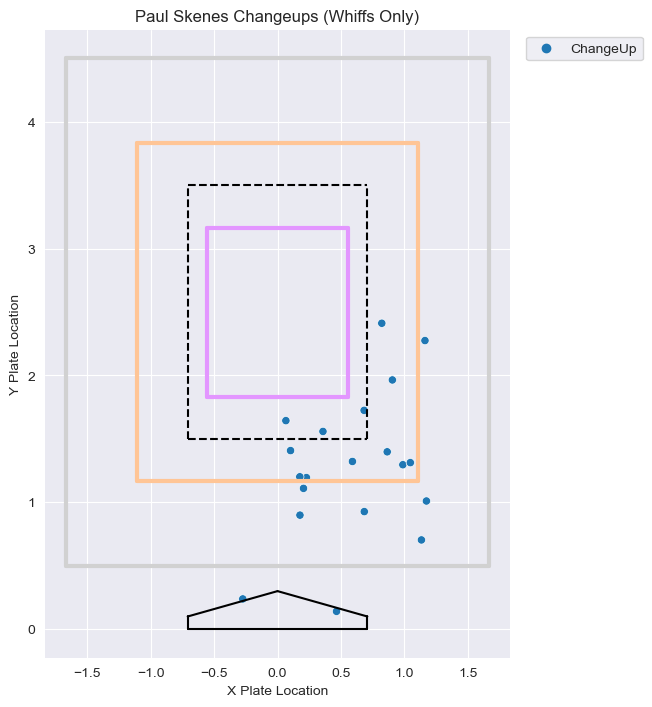

In [72]:
fig = plt.figure(figsize=(6,9))
fig = sns.scatterplot(data=skenes_os[skenes_os['PitchCall'] == 'StrikeSwinging'], x='PlateLocSide', y='PlateLocHeight',
                      hue='TaggedPitchType')

draw_sz(ls='k--')
draw_home_plate(False)
draw_attack_zones()
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine(left=True, bottom=True)
plt.title('Paul Skenes Changeups (Whiffs Only)')
plt.xlabel('X Plate Location')
plt.ylabel('Y Plate Location')
plt.show()

In [73]:
# Get unique values
unique_values = breaking_balls['Pitcher'].unique()

# Create a dictionary to store subsets
subsets = {value: breaking_balls[breaking_balls['Pitcher'] == value] for value in unique_values}

In [77]:
preds = model_bb.predict_proba(breaking_balls_X)[:,1]
mean_pred = np.mean(preds)

skenes_bb = subsets['Skenes, Paul']
skenes_bb_X = skenes[bb_preds]

whiff_preds = model_bb.predict_proba(skenes_bb_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Paul Skenes Breaking Ball stuff+:{np.mean(stuff*100)}")

Paul Skenes Breaking Ball stuff+:125.8446273803711


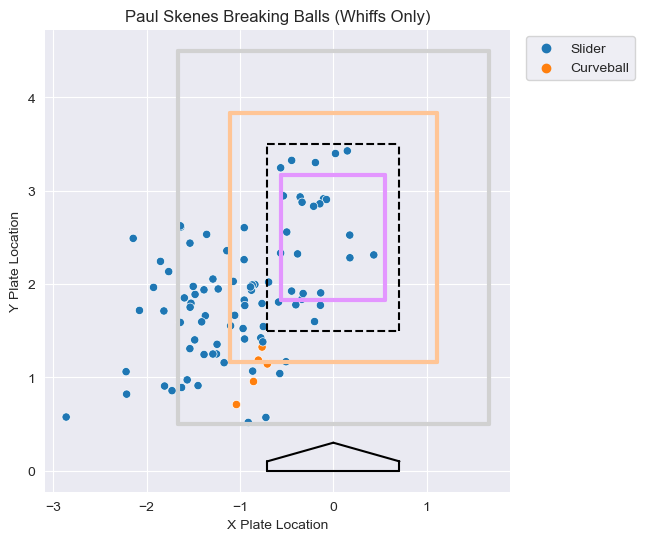

In [79]:
fig = plt.figure(figsize=(6,9))
fig = sns.scatterplot(data=skenes_bb[skenes_bb['PitchCall'] == 'StrikeSwinging'], x='PlateLocSide', y='PlateLocHeight',
                      hue='TaggedPitchType')

draw_sz(ls='k--')
draw_home_plate(False)
draw_attack_zones()
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine(left=True, bottom=True)
plt.title('Paul Skenes Breaking Balls (Whiffs Only)')
plt.xlabel('X Plate Location')
plt.ylabel('Y Plate Location')
plt.show()